# Refitting WT binding energies from glucose data 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [4]:
import sys
import numpy as np
import pandas as pd
import pystan
sys.path.insert(0, '../../')
import mwc.bayes
import mwc.stats
import mwc.viz
import altair as alt
import bokeh.io
import bebi103
alt.data_transformers.enable('json')
bokeh.io.output_notebook()
%load_ext stanmagic

Loading BokehJS ...

I would like to be able to have reliable confidence intervals based on my glucose data. While using the energies determined by Hernan is valid, I would reather determine the binding energy myself since I have reliable repressor counts.  

In [5]:
# Load the compiled data set. 
fc_data = pd.read_csv('../../data/compiled_fold_change.csv')

# Load the fluctutations
fluct_data = pd.read_csv('../../data/compiled_fluctuations.csv') 

# Isolate glucose data. 
gluc_fc = fc_data[(fc_data['carbon']=='glucose') & (fc_data['strain']=='dilution')].copy()
gluc_fluct = fluct_data[(fluct_data['carbon']=='glucose')].copy()

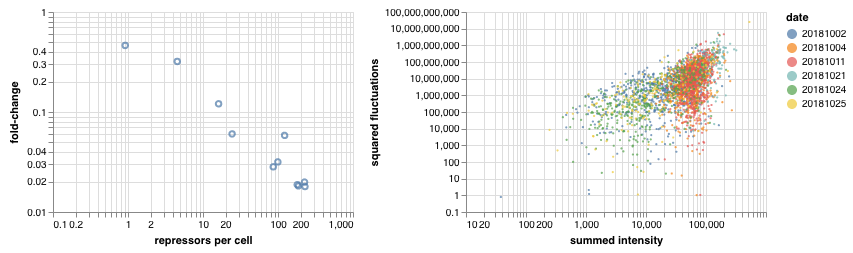

In [6]:
# Plot all glucose data. 
fc_points = alt.Chart(data=gluc_fc[gluc_fc['fold_change'] >= 0],
                     width=300, height=200).mark_point(
    ).encode(
        x=alt.X('mean_rep:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}), 
        y=alt.Y('mean_fc:Q', scale={'type':'log'}, axis={'title':'fold-change'})
    ).transform_aggregate(
        mean_rep='mean(repressors)',
        mean_fc='mean(fold_change)',
        groupby=['atc_ngml'])

# Plot the fluctuation data. 
fluct_points = alt.Chart(data=gluc_fluct[(gluc_fluct['summed'] > 0) &
                                        (gluc_fluct['sq_fluct'] > 0)],
                         width=300, height=200
    ).mark_point(filled=True, size=5
    ).encode(
    x=alt.X('summed:Q', scale={'type':'log'}, axis={'title':'summed intensity'}),
    y=alt.Y('sq_fluct:Q', scale={'type':'log'}, axis={'title':'squared fluctuations'}),
    color='date:N') 

fc_points | fluct_points

The goal here will be to simultaneously infer the calibration factor for each replicate of the glucose data and use that to infer the repressor copy number. The repressor copy number will then be used to infer the DNA binding energy. This becomes a somewhat complicated model, but should be easy to fit.  

In [7]:
# Add identifiers. 
gluc_fc = gluc_fc[gluc_fc['mean_mCherry'] >= 0].copy()
gluc_fc['conc_idx'] = gluc_fc.groupby(['atc_ngml']).ngroup() + 1
gluc_fc['run_idx'] = gluc_fc.groupby(['date', 'run_number']).ngroup() + 1
gluc_fc['conc_run_idx'] = gluc_fc.groupby(['date', 'run_number', 'atc_ngml']).ngroup() + 1
gluc_fluct['run_idx'] = gluc_fluct.groupby(['date', 'run_no']).ngroup() + 1
gluc_fc['tot_mcherry'] = gluc_fc['mean_mCherry'] * gluc_fc['area_pix']

# Assemble the data dictionary. 
data_dict = {'J_conc':gluc_fc['conc_idx'].max(),
            'J_runs':gluc_fc['run_idx'].max(),
            'J_conc_runs':gluc_fc['conc_run_idx'].max(),
            'N_fluct':len(gluc_fluct),
            'N_fc': len(gluc_fc),
            'fluct_index':gluc_fluct['run_idx'],
             'fc_index_run':gluc_fc['run_idx'],
            'fc_index_conc':[key[0] for key, value in gluc_fc.groupby(['conc_idx', 'conc_run_idx'])],
            'fc_conc_run_idx':gluc_fc['conc_run_idx'],
            'fc_index_replicates':gluc_fc['conc_run_idx'],
            'I_1': gluc_fluct['I_1'],
            'I_2': gluc_fluct['I_2'],
            'mCherry': gluc_fc['tot_mcherry'],
            'fc': gluc_fc['fold_change']}

# Load the stan model. 
# model = mwc.bayes.StanModel('../stan/simultaneous_epRA_cal_factor.stan', data_dict=data_dict)

# Reworking the inferential model

What I built above samples terribly slowly and with a huge number of divergences. I can rework it to be a bit simpler, I think, without sacrificing the error propagation I'm really after. First, let's think of the calculation of the repressor copy number per ATC concentration calculation. This is a simple hierarchical model of a set of repeated measurements, both technical and biological. This boils down to a case of computing the mean repressor copy number per experiment, which itself is drawn from a hyperparamter distribution. With the number of measurements I have for each replicate, however, it's not immediately obvious if this is necessary.  

To perform this comparison, we can infer the mean repressor copy number for a single concentration across all technical replicates and another across all technical replicates **and** all measurements. Below, I define two stan models that perform this inference

In [15]:
%%stan -v all_meas_hier
data {
    int<lower=1> J; // Number of replicates
    int<lower=1> N; // Number of measurements
    int<lower=1, upper=J> idx[N]; // Identification vector
    real<lower=0> mCherry[N];
}

parameters {
    // Hyper parameters
    real<lower=0> log_mCherry_1;
    real<lower=0> log_mCherry_sigma_1;
    
    // Low-level uncentered parameters
    vector[J] log_mCherry_2_raw;
    vector[J] log_mCherry_sigma_2_raw;
    
    // How the hyperparameters vary
    real<lower=0>  tau_log_mCherry;
    real<lower=0> tau_log_mCherry_sigma;
}

transformed parameters {
    // Uncenter the low-level parameters. 
    vector[J] log_mCherry_2 = log_mCherry_1 + tau_log_mCherry * log_mCherry_2_raw;
    vector[J] log_mCherry_sigma_2 = log_mCherry_sigma_1 + tau_log_mCherry_sigma * log_mCherry_sigma_2_raw;
    real mCherry_mu = exp(log_mCherry_1);
    vector[J] mCherry_2 = exp(log_mCherry_2);
    vector[J] sigma = exp(log_mCherry_sigma_2);
    
}

model {
    // Hyperpriors
    log_mCherry_1 ~ normal(0, 2);
    log_mCherry_sigma_1 ~ normal(0, 1);
   
    // Uncentering priors
    tau_log_mCherry ~ normal(0, 1);
    tau_log_mCherry_sigma ~ normal(0, 2);
    log_mCherry_2_raw ~ normal(0, 1);
    log_mCherry_sigma_2_raw ~ normal(0, 1);
    
    // Likelihood
    mCherry ~ normal(mCherry_2[idx], sigma[idx]);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in all_meas_hier object.
Type all_meas_hier in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^
Access model compile output properties
all_meas_hier.model_file -> Name of stan_file [None]
all_meas_hier.model_name -> Name of stan model [None]
all_meas_hier.model_code -> Model code [data {     int<lower ....]


In [16]:
%%stan -v simple_meas_hier
data {
    int<lower=1> N; // Number of measurements (of mean)
    real<lower=0> mCherry[N];
}

parameters {
    real<lower=0> log_mCherry_mu;
    real<lower=0> log_mCherry_sigma; 
}

transformed parameters {
    real<lower=0> mCherry_mu = exp(log_mCherry_mu);
    real<lower=0> mCherry_sigma = exp(log_mCherry_sigma);
}
model {
    log_mCherry_mu ~ normal(0, 2);
    log_mCherry_sigma ~ normal(0, 1);     
    mCherry ~ normal(mCherry_mu, mCherry_sigma);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in simple_meas_hier object.
Type simple_meas_hier in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^
Access model compile output properties
simple_meas_hier.model_file -> Name of stan_file [None]
simple_meas_hier.model_name -> Name of stan model [None]
simple_meas_hier.model_code -> Model code [data {     int<lower ....]


In [17]:
full_model = pystan.StanModel(model_code=all_meas_hier.model_code)
simple_model = pystan.StanModel(model_code=simple_meas_hier.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b32fc012cb25e534989d49be04e4dea1 NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++ [enabled by default]
In file included from /Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:0,
                 from /Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /var/folders/ls/9qrb9vy978l5jkf3_xdwxq9r0000gq/T/tmp02166sa_/stanfit4anon_model_b32fc012cb25e534989d49be04e4dea1_5513781669328633923.cpp:642:
/Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
/var/folders/ls/9qrb9vy978l5jkf3_xdwxq9r0000gq/T/tmp02166sa_/stanfit4ano

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a6a5cf3ff08aa1dcc8eed0c342bbf0cb NOW.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++ [enabled by default]
In file included from /Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:0,
                 from /Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /var/folders/ls/9qrb9vy978l5jkf3_xdwxq9r0000gq/T/tmpm692qxxa/stanfit4anon_model_a6a5cf3ff08aa1dcc8eed0c342bbf0cb_3486375645938521114.cpp:642:
/Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
/var/folders/ls/9qrb9vy978l5jkf3_xdwxq9r0000gq/T/tmpm692qxxa/stanfit4ano

In [18]:
# assemble the data dictionaries. 
conc_test =gluc_fc[gluc_fc['atc_ngml'] == 4.0].copy()
conc_test['run_idx'] = conc_test.groupby(['run_number', 'date']).ngroup() + 1
simple_conc_test = gluc_fc.groupby(['run_idx']).mean().reset_index()
all_meas_data_dict = {'J': conc_test['run_idx'].max(),
                     'N':len(conc_test),
                     'idx': conc_test['run_idx'],
                     'mCherry':conc_test['tot_mcherry']}
simple_meas_data_dict = {'N':len(simple_conc_test),
                   'mCherry':simple_conc_test['tot_mcherry']}

full_samples = full_model.sampling(data=all_meas_data_dict, iter=8000, chains=4, thin=10)
simple_samples = simple_model.sampling(data=simple_meas_data_dict, iter=5000, chains=4)

In [19]:
simple_df = simple_samples.to_dataframe()
full_df = full_samples.to_dataframe()
hist, bins= np.histogram(simple_df['mCherry_mu'], bins=50)
hist2, bins2 = np.histogram(full_df['mCherry_mu'], bins=50)
p = bokeh.plotting.figure(width=300, height=300)
p.step(bins, hist)
p.step(bins2, hist2, color='tomato')
bokeh.io.show(p)

/Users/gchure/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 51), ('y', 50)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/Users/gchure/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 51), ('y', 50)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [76]:
full_df.keys()

Index(['chain', 'chain_idx', 'warmup', 'divergent__', 'energy__',
       'treedepth__', 'accept_stat__', 'stepsize__', 'n_leapfrog__',
       'log_mCherry_1', 'log_mCherry_sigma_1', 'log_mCherry_2_raw[1]',
       'log_mCherry_2_raw[2]', 'log_mCherry_2_raw[3]', 'log_mCherry_2_raw[4]',
       'log_mCherry_sigma_2_raw[1]', 'log_mCherry_sigma_2_raw[2]',
       'log_mCherry_sigma_2_raw[3]', 'log_mCherry_sigma_2_raw[4]',
       'tau_log_mCherry', 'tau_log_mCherry_sigma', 'log_mCherry_2[1]',
       'log_mCherry_2[2]', 'log_mCherry_2[3]', 'log_mCherry_2[4]',
       'log_mCherry_sigma_2[1]', 'log_mCherry_sigma_2[2]',
       'log_mCherry_sigma_2[3]', 'log_mCherry_sigma_2[4]', 'mCherry_2[1]',
       'mCherry_2[2]', 'mCherry_2[3]', 'mCherry_2[4]', 'sigma[1]', 'sigma[2]',
       'sigma[3]', 'sigma[4]', 'lp__'],
      dtype='object')